<center><h1> PDE: Uninformed Sensor Placement

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# import matplotlib.tri as tri
from scipy.stats import distributions as dist
# from mud import full_functional, norm_input, norm_data, norm_predicted,  
from mud.plot import make_2d_unit_mesh
from mud.util import std_from_equipment

In [2]:
plt.rcParams['figure.figsize'] = 10,10
plt.rcParams['font.size'] = 16

In [3]:
from newpoisson import poisson, poisson_sensor_model
import pickle

In [4]:
prefix      = 'pde'
num_measure = 1000 # number of measurement (sensor) locations
fsize       = 32
num_trials  = 20   # realizations of synthetic data for numerical runs
tolerance   = 0.1 # precision of measurement equipment
sigma       = std_from_equipment(tolerance=tolerance, probability=0.99)
np.random.seed(21)

In [5]:
results = pickle.load(open('res1u.pkl', 'rb'))
# flatten results structure
l = []
for r in results:
    for w in r.values():
        l.append(w)

In [6]:
num_samples = len(l)
print(f"Loaded {num_samples} evaluation of parameter space.")

Loaded 1000 evaluation of parameter space.


---

# Define Sensors

In [7]:
# sensors = np.array([(0.8, yi) for yi in np.linspace(0.2,0.8,num_sensors)])
# sensors = np.array([(xi,0.8) for xi in np.linspace(0.2,0.8,num_sensors)])
# sensors = np.random.rand(num_measure,2)
# sensors = np.mgrid[0.2:0.8:20j,0.2:0.8:20j].reshape(2,400).T

# num_measure = sensors.shape[0]

---

# Load Files + Evaluate 

In [8]:
from fenics import FunctionSpace, RectangleMesh, Point, Function

In [9]:
# %%time
gamma_true = 3.0
sensors     = np.random.rand(num_measure,2)*0.9 + 0.05
qoi_true = poisson_sensor_model(sensors, gamma=gamma_true, nx=36, ny=36)

mesh = RectangleMesh(Point(0,0), Point(1,1), 36, 36)
V = FunctionSpace(mesh, 'Lagrange',1)

qoi = []
gamma = []
# go through all the files and load them into an array
for i in range(len(l)):
    fname = l[i]['u']
    u = Function(V,fname)
    q = [u(xi,yi) for xi,yi in sensors] # sensors
    qoi.append(np.array(q))
    gamma.append(l[i]['gamma'])
qoi = np.array(qoi)
gamma = np.array(gamma)
a = np.argsort(gamma)
print(qoi.shape, gamma.shape, sensors.shape) # check shapes correct

(1000, 1000) (1000,) (1000, 2)


---
---

# Solve Inverse Problem

In [10]:
import bet.sample as samp

In [11]:
def mud_problem(lam, qoi, sd=0.05, num_obs=None, qoi_true=qoi_true):
    try:
        dim_input = lam.shape[1]
    except IndexError:
        dim_input = 1

    try:
        dim_output = qoi.shape[1]
    except IndexError:
        dim_output = 1

    if num_obs is None:
        num_obs = dim_output
    elif num_obs < 1:
        raise ValueError("num_obs must be >= 1")
    elif num_obs > dim_output:
        raise ValueError("num_obs must be <= dim(qoi)")

    i_set = samp.sample_set(dim_input)
    i_set.set_domain(np.array([[1,5]])) # TODO: generalize domain
    
    i_set.set_values(lam)
    o_set = samp.sample_set(dim_output)
    o_set.set_values(qoi)
    d = samp.discretization(i_set, o_set)
    data = qoi_true[0:num_obs] + np.random.randn(num_obs)*sd
    
    # TODO generalize
    d.set_initial(dist=dist.uniform(loc=1,scale=4), gen=False)
    # needed if changing dimensions around until fix is made in BET
#     d._output_probability_set = None # will throw warning
    d._output_probability_set = samp.sample_set(num_obs)
    d.data_driven(data=data, std=sd, inds=list(range(0,num_obs)))
    return d

# What happens as we take more observations?

## Make MUD solutions for successive inclusions of measurements

We take repeated trials (draws of noise polluting our data) to study the sensitivity to individual experiments as a function of number of observations.

In [12]:
num_sensor_list = np.arange(num_measure) + 1
# num_sensors_plot_conv = num_sensor_list[4::5]
# num_sensors_plot_conv = num_sensor_list[9::10]
# num_sensors_plot_conv = num_sensor_list[24::25]
num_sensors_plot_conv = [5, 10, 15, 20, 25, 50, 100, 250, 500, 1000]
print(f"Will run simulations for {num_sensors_plot_conv}")

Will run simulations for [5, 10, 15, 20, 25, 50, 100, 250, 500, 1000]


In [13]:
%%time
experiments = {}
solutions = {}
for ns in num_sensors_plot_conv:
    discretizations = []
    mud_solutions = []
    for t in range(num_trials):
        np.random.seed(21+t)
        _d = mud_problem(gamma, qoi, sd=sigma, num_obs=ns)
        discretizations.append(_d)
        mud_solutions.append(_d.mud_point())
    experiments[ns] = discretizations
    solutions[ns] = mud_solutions

CPU times: user 5.75 s, sys: 439 ms, total: 6.19 s
Wall time: 6.2 s


## extract means and variances from repeated trials

In [14]:
means = []
variances = []
for ns in num_sensors_plot_conv:
    mud_solutions = solutions[ns]
    err = np.abs(np.array(mud_solutions) - gamma_true)
    mean_mud_sol = np.mean(err)
    var_mud_sol = np.var(err)
    means.append(mean_mud_sol)
    variances.append(var_mud_sol)

## How does the accuracy + precision change?

In [15]:
x, ym, yv = np.log10(num_sensors_plot_conv), np.log10(means), np.log10(variances)

slope_mean, intercept_mean = (np.linalg.pinv(np.vander(x, 2))@np.array(ym).reshape(-1,1)).ravel()
slope_var, intercept_var = (np.linalg.pinv(np.vander(x, 2))@np.array(yv).reshape(-1,1)).ravel()

regression_mean = slope_mean*x + intercept_mean
regression_var  = slope_var*x + intercept_var

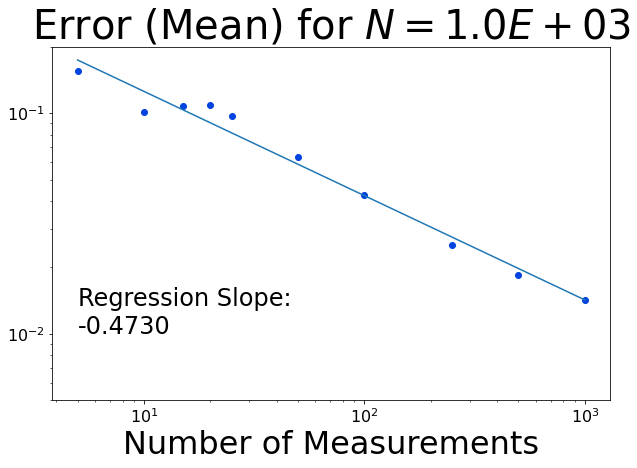

In [16]:
plt.figure(figsize=(10,10))
plt.scatter(num_sensors_plot_conv, means, label='mean', c='xkcd:blue')
plt.plot(num_sensors_plot_conv, 10**regression_mean)
plt.annotate(f"Regression Slope:\n{slope_mean:1.4f}", (num_sensors_plot_conv[0],0.01), fontsize=24)

plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(5E-3,2E-1)
plt.xlabel('Number of Measurements', fontsize=fsize)
# plt.ylabel('Absolute Error in MUD', fontsize=fsize)
plt.title(f"Error (Mean) for $N={gamma.shape[0]:1.1E}$", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_obs_mean.pdf')
plt.show()

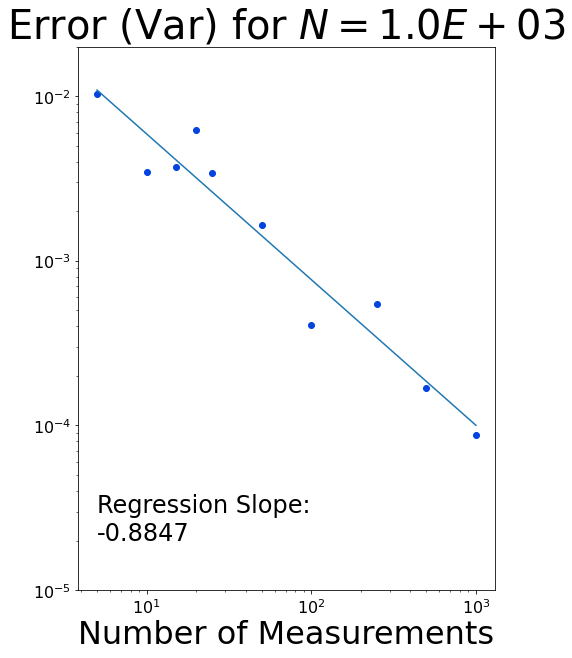

In [17]:
plt.figure(figsize=(10,10))
plt.scatter(num_sensors_plot_conv, variances, label='variance', c='xkcd:blue')
plt.plot(num_sensors_plot_conv, 10**regression_var)
plt.annotate(f"Regression Slope:\n{slope_var:1.4f}", (num_sensors_plot_conv[0],2E-5), fontsize=24)

plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(1E-5, 2E-2)
plt.xlabel('Number of Measurements', fontsize=fsize)
# plt.ylabel('Absolute Error in MUD', fontsize=fsize)
plt.title(f"Error (Var) for $N={gamma.shape[0]:1.1E}$", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_obs_var.pdf')
plt.show()

---

## Measurement Error

Fixed number of sensors, varying the quality of equipment.


In [18]:
%%time
sd_err = []
sd_var = []
tolerances = [0.1, 0.05, 0.01, 0.005, 0.001]
sd_vals = [ std_from_equipment(tolerance=tol, probability=0.99) for tol in tolerances ]

num_sensors = 100
for sd in sd_vals:
    temp_err = []
    for t in range(num_trials):
        d = mud_problem(gamma, qoi, sd=sd, qoi_true=qoi_true, num_obs=num_sensors)
        mud_point = d.mud_point()
        temp_err.append(np.abs(mud_point - gamma_true))
    sd_err.append(np.mean(temp_err))
    sd_var.append(np.var(temp_err))

CPU times: user 2.81 s, sys: 7.63 ms, total: 2.82 s
Wall time: 2.82 s


In [19]:
xx, yym, yyv = np.log10(tolerances), np.log10(sd_err), np.log10(sd_var)

slope_err_mean, intercept_err_mean = (np.linalg.pinv(np.vander(xx, 2))@np.array(yym).reshape(-1,1)).ravel()
slope_err_var, intercept_err_var = (np.linalg.pinv(np.vander(xx, 2))@np.array(yyv).reshape(-1,1)).ravel()

regression_err_mean = slope_err_mean*xx + intercept_err_mean
regression_err_var  = slope_err_var*xx + intercept_err_var

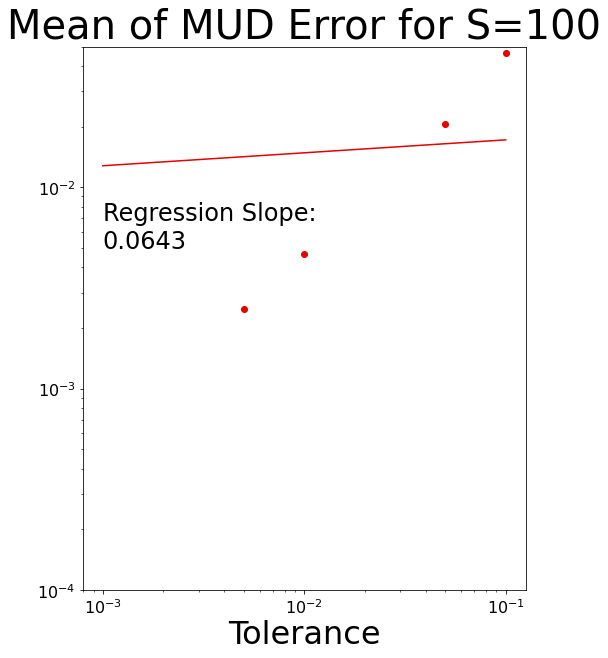

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(tolerances, sd_err, label='mean', c='xkcd:red')
plt.plot(tolerances, 10**regression_err_mean, label='mean', c='xkcd:red')
# plt.plot(sd_vals, np.power(np.array(sd_vals), 1), label='$\sigma$', ls='--',  c='xkcd:red')

plt.annotate(f"Regression Slope:\n{slope_err_mean:1.4f}", (tolerances[-1],5E-3), fontsize=24)
plt.yscale('log')
plt.xscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(1E-4, 5E-2)
# plt.ylabel("Absolute Error", fontsize=fsize)
plt.xlabel("Tolerance", fontsize=fsize)
plt.title(f"Mean of MUD Error for S={num_sensors}", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_std_mean.pdf')
plt.show()

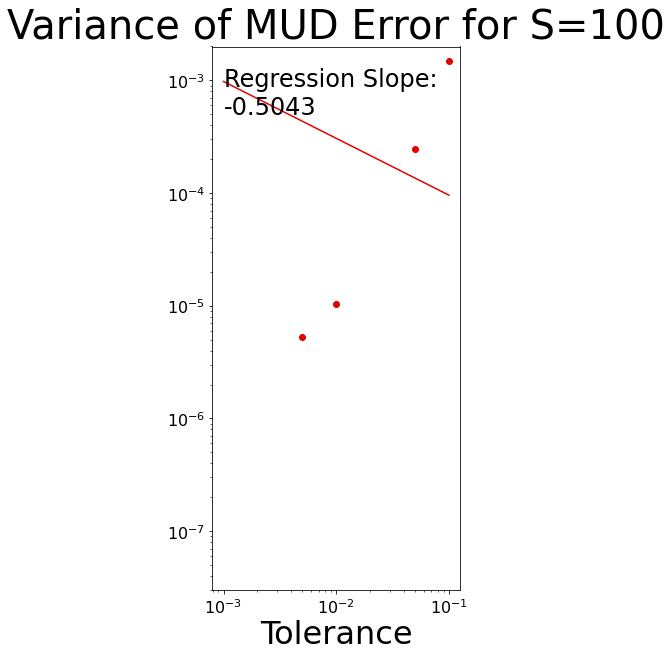

In [21]:
plt.figure(figsize=(10,10))

plt.scatter(tolerances, sd_var, label='mean', c='xkcd:red')
plt.plot(tolerances, 10**regression_err_var, label='mean', c='xkcd:red')
# plt.plot(sd_vals, np.power(np.array(sd_vals), 2), label='$\sigma^2$', ls='--', c='xkcd:blue')
plt.annotate(f"Regression Slope:\n{slope_err_var:1.4f}", (tolerances[-1],5E-4), fontsize=24)

plt.xscale('log')
plt.yscale('log')
plt.Axes.set_aspect(plt.gca(), 1)
plt.ylim(3E-8, 2E-3)
# plt.xlim(1E-3, 1E-1)

# plt.ylabel("Absolute Error", fontsize=fsize)
plt.xlabel("Tolerance", fontsize=fsize)
plt.title(f"Variance of MUD Error for S={num_sensors}", fontsize=1.25*fsize)
plt.savefig(f'{prefix}_convergence_mud_std_var.pdf')
plt.show()

---
---

# Sensitivity of Measurements to Parameter

In [22]:
# from fenics import File, FunctionSpace, Function, RectangleMesh, Point, Mesh
# special plotting functions
import matplotlib.gridspec as gridspec
from fenics import plot as _plot

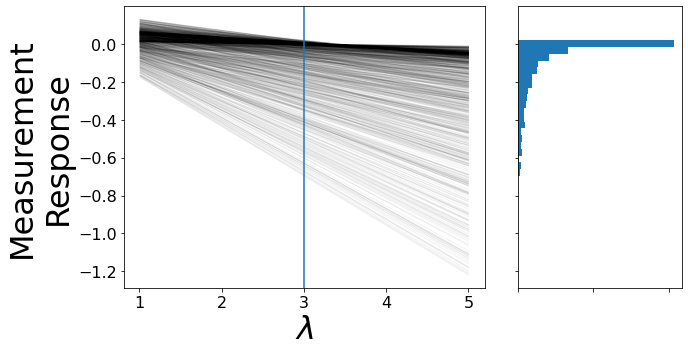

In [41]:
plot_num_measure = 1000
raveled_input = np.repeat(gamma, qoi.shape[1])
raveled_output = qoi.reshape(-1)
x = raveled_input
y = raveled_output

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(3, 3)
ax_main = plt.subplot(gs[1:3, :2])
# ax_xDist = plt.subplot(gs[0, :2],sharex=ax_main)
ax_yDist = plt.subplot(gs[1:3, 2],sharey=ax_main)

slopes = []
# ax_main.plot(x,y,marker='.')
for idx in range(plot_num_measure):
    ax_main.plot(gamma[a], qoi[a,idx], c='k', 
             label=f'sensor {idx}: (%.2f, %.2f)'%(sensors[idx,0], sensors[idx,1]), 
             lw=1, alpha=0.05)
    slopes.append(qoi[a[-1],idx] - qoi[a[0],idx])
sa = np.argsort(slopes)
slopes = np.array(slopes)
ranked_slopes = slopes[sa]

xlabel_text = "$\lambda$"
# ylabel_text = "$u(x_i, \lambda)$"
ylabel_text = "Measurement\nResponse"
ax_main.axes.set_xlabel(xlabel_text, fontsize=fsize)
ax_main.axes.set_ylabel(ylabel_text, fontsize=fsize)
# ax_main.axes.set_title('Sensitivity of Measurements', fontsize=1.25*fsize)
ax_main.axvline(3)

# ax_xDist.hist(gamma,bins=50,align='mid')
# ax_xDist.set(ylabel='count')
# ax_xDist.tick_params(labelbottom=False)
# ax_xCumDist = ax_xDist.twinx()
# # ax_xCumDist.hist(x,bins=100,cumulative=True,histtype='step',density=True,color='r',align='mid')
# ax_xCumDist.tick_params('y', colors='r')
# ax_xCumDist.set_ylabel('cumulative',color='r')

ax_yDist.hist(qoi_true, bins=20, orientation='horizontal', align='mid')
# ax_yDist.set(xlabel='count')
ax_yDist.tick_params(labelleft=False, labelbottom=False)
# ax_yCumDist = ax_yDist.twiny()
# ax_yCumDist.hist(y,bins=20,cumulative=True,histtype='step',density=True,color='r',align='mid',orientation='horizontal')
# ax_yCumDist.tick_params('x', colors='r')
# ax_yCumDist.set_xlabel('cumulative',color='r')
plt.savefig(f'{prefix}_qoi_response.png', layout='tight')
plt.show()

---

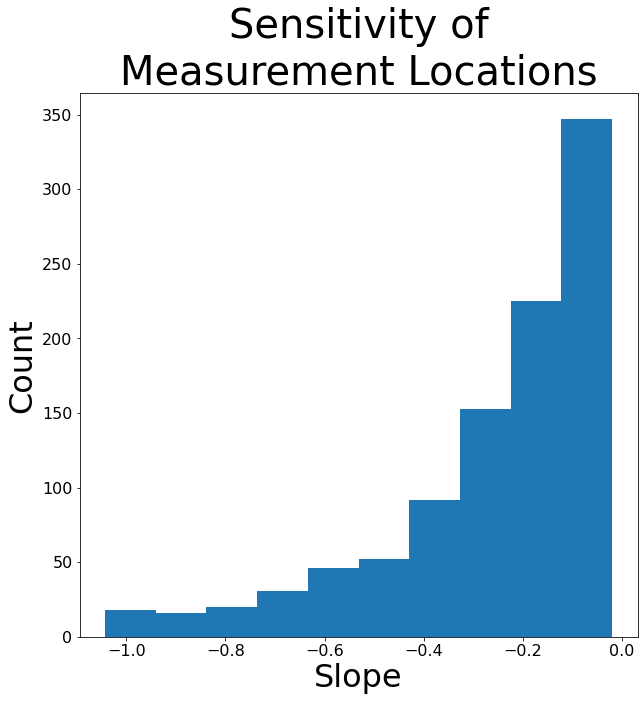

In [24]:
plt.title("Sensitivity of\nMeasurement Locations", fontsize=1.25*fsize)
plt.hist(ranked_slopes)
plt.ylabel("Count", fontsize=fsize)
plt.xlabel("Slope", fontsize=fsize)
plt.savefig(f'{prefix}_sensitivity_qoi.pdf')
plt.show()

In [25]:
print(f"The ratio of most to least sensitive is {ranked_slopes[0]/ranked_slopes[-1]}")

The ratio of most to least sensitive is 52.24698810545966


In [26]:
print("Most sensitive sensors in first 100:")
num_sensitive  = 20
most_sensitive = sa[sa < 100][0:num_sensitive]
print(most_sensitive)

Most sensitive sensors in first 100:
[58 69  0 54 27 68 53 76 79 71 28 97  6  5  4 15  3 35 46 14]


---

# Plot Response Surface

In [27]:
gamma_true

3.0

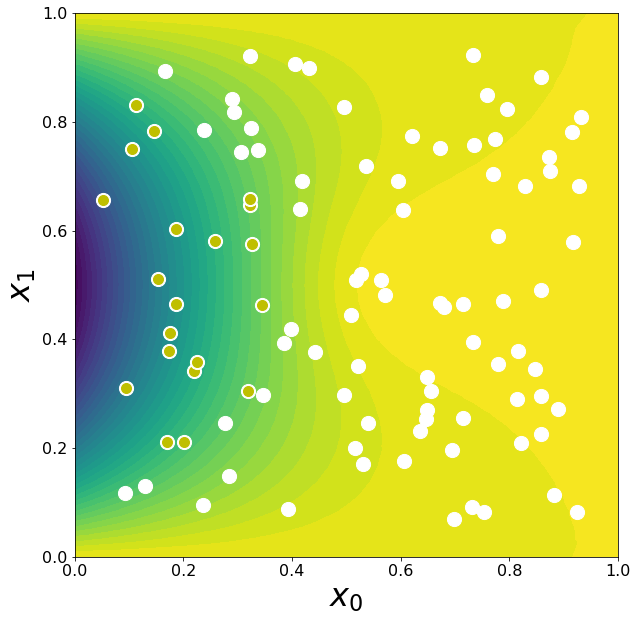

In [28]:
_plot(poisson(gamma_true))
for i in range(100):
    plt.scatter(sensors[i,0], sensors[i,1], c='w', s=200)
    if i in most_sensitive:
        plt.scatter(sensors[i,0], sensors[i,1], c='y', s=100)
#     plt.annotate(f"{i+1:02d}", (sensors[i,0]-0.0125, sensors[i,1]-0.01), alpha=1, fontsize=0.35*fsize)
# plt.title('Reference solution', fontsize=1.25*fsize)
plt.xlabel('$x_0$', fontsize=fsize)
plt.ylabel('$x_1$', fontsize=fsize)
plt.savefig(f'{prefix}_reference_solution.pdf', bbox_inches='tight')
plt.show()

---

# Range of Values of Measurements

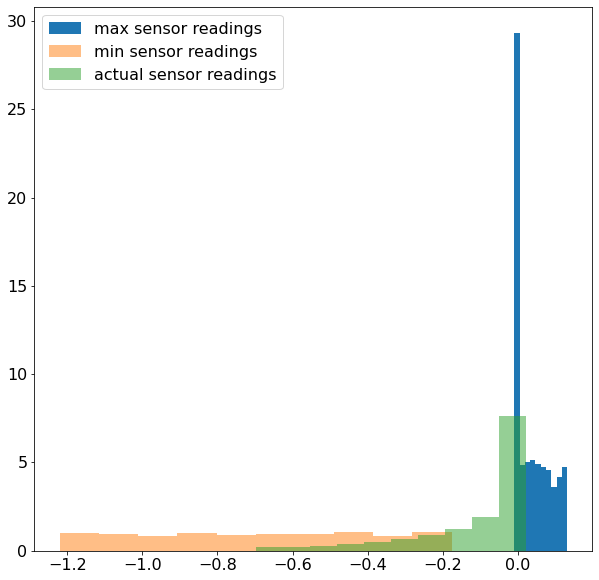

In [29]:
sensor_mins = np.min(qoi, axis=1)
sensor_maxs = np.max(qoi, axis=1)
plt.hist(sensor_maxs, density=True, label='max sensor readings')
plt.hist(sensor_mins, density=True, alpha=0.5, label='min sensor readings')

plt.hist(qoi_true, density=True, alpha=0.5, label='actual sensor readings')
plt.legend()
plt.show()

---

## Contour reconstructed from sensor values
### WARNING : will not work if all the sensors are in-line...

Range of values: 0.3964608009928338


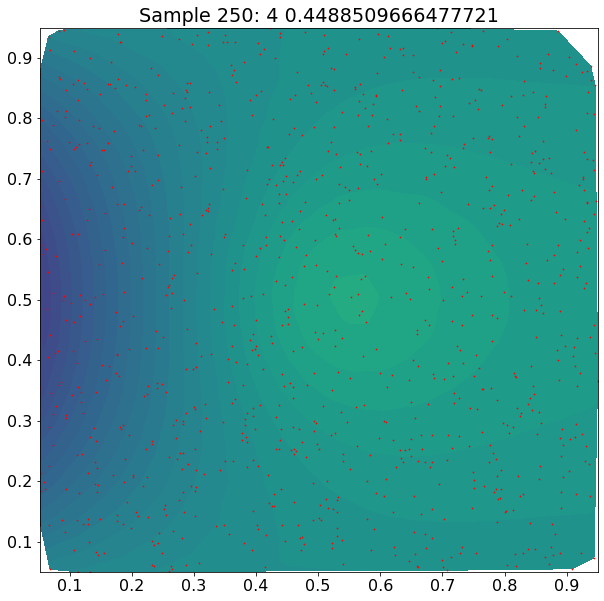

In [30]:
idx = 250  # some index into the parameter samples

try:
    z = qoi[idx,:]
    x, y = sensors[:,0], sensors[:,1]
    plt.tricontourf(x, y, z, levels=20, vmin=-0.5, vmax=0.5)
    plt.scatter(x,y,c='r',s=0.5)
    sidx = 4 # sensor index
    plt.title(f"Sample {idx}: {sidx} {(qoi[:,sidx].max() - qoi[:,sidx].min())}")
    print("Range of values:", z.max() - z.min())
    plt.show()

    z = qoi_true
    plt.tricontourf(x, y, z, levels=20, vmin=-0.5, vmax=0.5)
    plt.scatter(x,y,c='r',s=0.5)
    plt.title("Truth")
    print("Range of values:", z.max() - z.min())
    plt.show()
except:
    plt.close()
    pass

---

# Solution Plots

In [31]:
sigma2 = 0.001
num_sensors_plot = 50
d = mud_problem(gamma, qoi, sd=np.sqrt(sigma2), num_obs=num_sensors_plot)

Text(0.5, 1.0, 'S=50 | $\\sigma^2$=0.001 | $\\lambda^\\dagger$=2.8911342242204867')

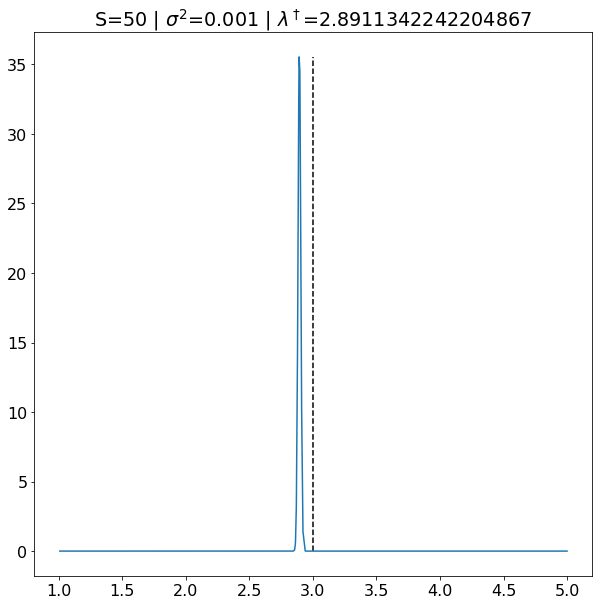

In [32]:
updated = d.updated_pdf()
# plt.scatter(d.get_input_values(), updated)
plt.plot(gamma[a], updated[a], label='updated density')
plt.vlines(gamma_true, 0, np.max(updated[a]), label='truth', ls='--')

title_updated = f"S={num_sensors_plot} | $\sigma^2$={sigma2} | $\lambda^\dagger$={d.mud_point()[0]}"
plt.title(title_updated)
# plt.savefig(f'{prefix}_updated_pde.pdf')

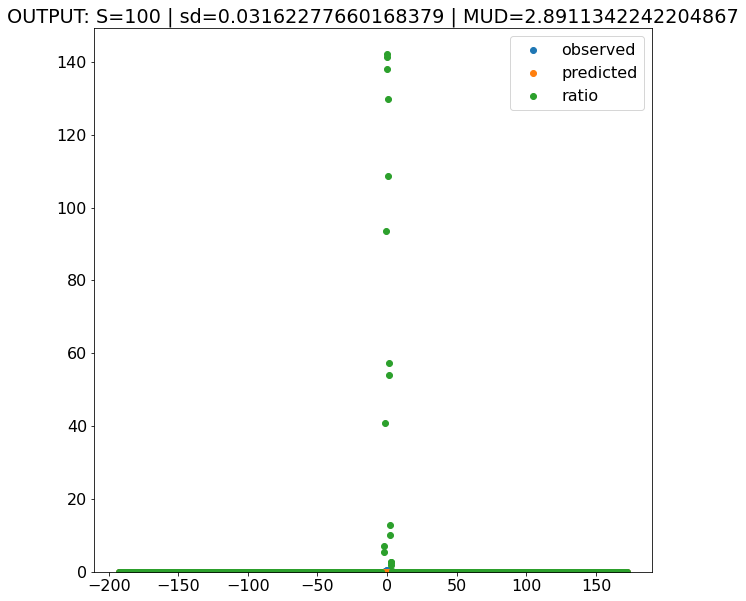

In [33]:
obs_vals = d.format_output_values()
plt.hist(obs_vals, density=True, alpha=0.1)
plt.scatter(obs_vals, d.observed_pdf(), label='observed')
plt.scatter(obs_vals, d.predicted_pdf(), label='predicted')
plt.scatter(obs_vals, d.ratio_pdf(), label='ratio')
plt.legend()
# plt.xlim(-3,3)
plt.title(f"OUTPUT: S={num_sensors} | sd={np.min(d.get_std())} | MUD={d.mud_point()[0]}")
plt.show()

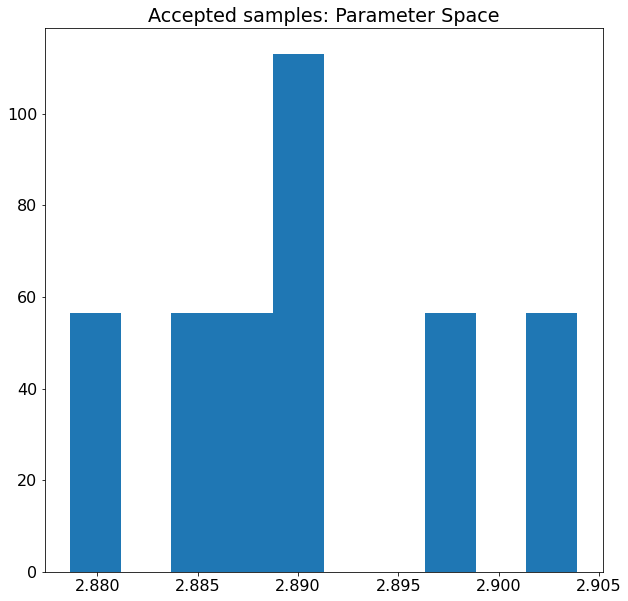

In [34]:
# perform accept/reject
dc = d.clip_accepted_samples()
plt.hist(dc.get_input_values(), density=True)
plt.title("Accepted samples: Parameter Space")
plt.show()

In [35]:
dc.get_output_values()

array([[-0.49404913, -0.00262801, -0.10109077, ..., -0.50811508,
         0.00764971, -0.15650355],
       [-0.49342978, -0.00260026, -0.10094871, ..., -0.50748243,
         0.00775506, -0.15630732],
       [-0.49711526, -0.0027654 , -0.10179404, ..., -0.51124711,
         0.00712817, -0.15747501],
       ...,
       [-0.49459797, -0.00265261, -0.10121665, ..., -0.50867572,
         0.00755635, -0.15667744],
       [-0.49580524, -0.0027067 , -0.10149356, ..., -0.50990894,
         0.007351  , -0.15705995],
       [-0.49454739, -0.00265034, -0.10120505, ..., -0.50862405,
         0.00756496, -0.15666142]])

In [36]:
# TODO: put this into BET (as get_qoi_values?)
pred_qoi = np.sum(dc.get_output_values()[:,dc.get_output_indices()] - d.get_data(), axis=1)/np.sqrt(num_sensors*sigma**2)

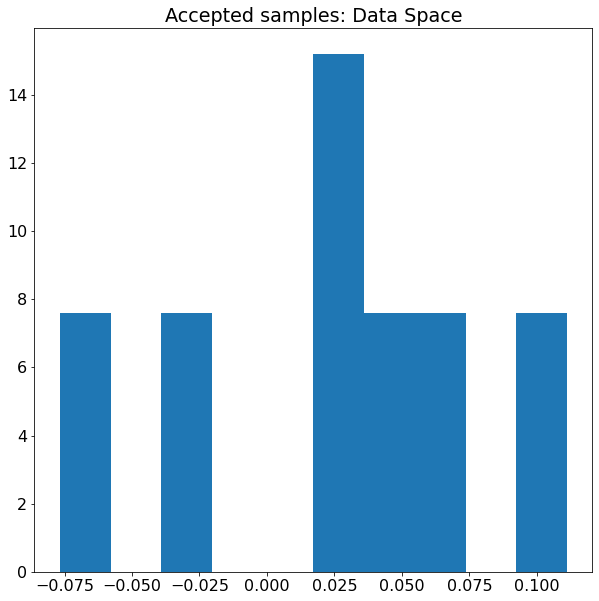

In [37]:
plt.hist(pred_qoi, density=True)
plt.title("Accepted samples: Data Space")
plt.show()

In [38]:
pred_qoi.mean(), pred_qoi.std(), pred_qoi.shape

(0.021012021879059352, 0.05615156420458487, (7,))